## VWAP Reversion EDA — Research Overview

- Research question: What is the empirical probability that intraday price reverts to VWAP after a sufficiently large deviation, and how does that probability vary by higher-timeframe regime (Hurst), deviation size, time-of-day, and volatility?
- Data: Polygon 5-minute aggregates for crypto assets; key columns: open, high, low, close, volume, vwap. API key read from `polygon_key.txt`.
- Event definition:
  - Trigger: |close − anchored VWAP| / anchored VWAP ≥ threshold (e.g., 0.5%, 1.0%, 1.5%). Anchored VWAP resets per UTC day.
  - Outcome (success): signed deviation flips across zero within N bars (e.g., 5, 10, 20), capturing a return to VWAP.
- Context (regimes): Rolling Hurst (R/S) on 1H returns, smoothed with EMA; label MR ≤ 0.45, NOISY 0.45–0.55, TREND ≥ 0.55.
- EDA outputs:
  - Base P(revert) by regime and asset; conditional structure by deviation bin × regime × side; time-of-day and volatility slices; stability over time (first vs second half).
  - Visuals: heatmaps, reliability curves, Hurst plot with bands, time-of-day curves, TTR histograms.
- Decision gate (EDA-only): STOP if rare/flat/unstable; KEEP if base edge exists, conditional structure is monotonic, and stability is acceptable. Gate evaluated per-asset and overall.
- Packaging: Each run is saved to `studies/<timestamp>_VWAP_Reversion/` with config, summary tables, and plots so the workspace remains clean.

How to reuse for a new study:
- Edit `ASSETS`, `START/END`, `DEV_THRESH`, `HORIZONS`, and `STUDY_NAME` in the config cell.
- Run top-to-bottom. Caching (data_cache/) avoids refetching; per-asset gating prevents weak assets from blocking the study.


In [1]:
# Notebook starter
# This cell creates a local .venv for THIS notebook and installs requirements.
import os, sys, subprocess
from pathlib import Path

ROOT = Path.cwd().resolve()
VENV_DIR = ROOT / '.venv'
REQ = ROOT / 'requirements.txt'
if not REQ.exists():
    # Fallback to workspace requirements
    REQ = ROOT.parent / 'requirements.txt'

# Create venv if missing
if not VENV_DIR.exists():
    subprocess.run([sys.executable, '-m', 'venv', str(VENV_DIR)], check=True)

# Pip path inside venv
PIP = VENV_DIR / ('Scripts' if sys.platform.startswith('win') else 'bin') / ('pip.exe' if sys.platform.startswith('win') else 'pip')
PY = VENV_DIR / ('Scripts' if sys.platform.startswith('win') else 'bin') / ('python.exe' if sys.platform.startswith('win') else 'python')

# Install minimal requirements
if REQ.exists():
    subprocess.run([str(PIP), 'install', '--upgrade', 'pip'], check=True)
    subprocess.run([str(PIP), 'install', '-r', str(REQ)], check=True)

print('Local venv ready:', VENV_DIR)


Local venv ready: /Users/justinborneo/Desktop/Desktop - Justin’s MacBook Pro/Trading Research/.venv


In [2]:
# Kernel switch to local venv
import os, sys
from pathlib import Path
ROOT = Path.cwd().resolve()
VENV_DIR = ROOT / '.venv'
PY = VENV_DIR / ('Scripts' if sys.platform.startswith('win') else 'bin') / ('python.exe' if sys.platform.startswith('win') else 'python')
if Path(sys.executable).resolve() != PY.resolve():
    os.execv(str(PY), [str(PY), '-m', 'ipykernel_launcher', '-f', sys.argv[-1]])
else:
    print('Using local venv kernel')


Using local venv kernel


### 2) Imports & Config
This cell defines study parameters and verifies core imports are available.
- Assets (crypto only)
- Date range
- Intraday bar (5m), Hurst params, deviation thresholds, horizons
- Study name used when packaging


In [ ]:
# 2) Imports & Config
import importlib, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Parameters
ASSETS = [
    'X:BTCUSD','X:ETHUSD','X:SOLUSD','X:XRPUSD',
    'X:ADAUSD','X:DOGEUSD','X:AVAXUSD','X:DOTUSD','X:MATICUSD'
]
START, END = '2023-01-01', '2025-09-01'
INTRADAY_MULTIPLIER = 5
H_WIN, H_EMA, H_BANDS = 200, 8, (0.45, 0.55)
DEV_THRESH = [0.5, 1.0, 1.5]
HORIZONS = [5, 10, 20]
STUDY_NAME = 'VWAP_Reversion'

# Confirm imports
for m in ['polygon','pandas','numpy','matplotlib','sklearn','scipy','plotly']:
    try:
        importlib.import_module(m)
        print(f'OK import: {m}')
    except Exception as e:
        print(f'Import warning: {m}: {e}')


OK import: polygon
OK import: pandas
OK import: numpy
OK import: matplotlib
OK import: sklearn
OK import: scipy
OK import: plotly


In [15]:
# 3) Helpers Import (with safe reload)
# Loads reusable utilities for auth, data, features, Hurst/regimes, events, EDA checks, and packaging.
import sys, importlib
if 'helpers' in sys.modules:
    importlib.reload(sys.modules['helpers'])
else:
    import helpers  # noqa: F401
    importlib.reload(helpers)

from helpers import (
    read_polygon_key, get_polygon_client, fetch_aggregates,
    compute_vwap, rolling_sigma, atr, time_of_day_bucket,
    rolling_hurst, label_h_regime,
    deviation_pct_from_vwap, label_vwap_reversion,
    conditional_probability_table, reliability_curve,
    plot_heatmap, split_time_halves, terciles,
    monotonicity_check, stability_summary, decision_gate,
    package_study,
)
print('Helpers imported (reloaded).')


Helpers imported (reloaded).


### 4) Data Loading
Fetch 5m aggregates from Polygon for each asset and build a coverage table.
Notes:
- Crypto tickers are normalized (e.g., BTC-USD → X:BTCUSD) in helpers.
- DataFrame index is tz-aware (UTC).


In [5]:
# 4) Data Loading
assets_data = {}
for sym in ASSETS:
    df = fetch_aggregates(sym, START, END, multiplier=INTRADAY_MULTIPLIER, timespan='minute')
    assets_data[sym] = df
    print(sym, len(df), df.index.min(), '->', df.index.max())

# Coverage table
rows = []
for sym, df in assets_data.items():
    rows.append({
        'asset': sym,
        'start': str(df.index.min()) if len(df) else None,
        'end': str(df.index.max()) if len(df) else None,
        'rows': len(df),
        'missing_pct': round(100*df.isna().mean().mean() if len(df) else 100.0, 2),
    })
coverage = pd.DataFrame(rows)
coverage


X:BTCUSD 280785 2023-01-01 00:00:00+00:00 -> 2025-09-01 23:55:00+00:00
X:ETHUSD 280769 2023-01-01 00:00:00+00:00 -> 2025-09-01 23:55:00+00:00
X:SOLUSD 280378 2023-01-01 00:00:00+00:00 -> 2025-09-01 23:55:00+00:00
X:BNBUSD 0 nan -> nan
X:XRPUSD 280294 2023-01-01 00:00:00+00:00 -> 2025-09-01 23:55:00+00:00
X:ADAUSD 280176 2023-01-01 00:00:00+00:00 -> 2025-09-01 23:55:00+00:00
X:DOGEUSD 280570 2023-01-01 00:00:00+00:00 -> 2025-09-01 23:55:00+00:00
X:AVAXUSD 280659 2023-01-01 00:00:00+00:00 -> 2025-09-01 23:55:00+00:00
X:DOTUSD 280360 2023-01-01 00:00:00+00:00 -> 2025-09-01 23:55:00+00:00
X:MATICUSD 279482 2023-01-01 00:00:00+00:00 -> 2025-09-01 23:55:00+00:00


,asset,start,end,rows,missing_pct
0,X:BTCUSD,2023-01-01 00:00:00+00:00,2025-09-01 23:55:00+00:00,280785,0.0
1,X:ETHUSD,2023-01-01 00:00:00+00:00,2025-09-01 23:55:00+00:00,280769,0.0
2,X:SOLUSD,2023-01-01 00:00:00+00:00,2025-09-01 23:55:00+00:00,280378,0.0
3,X:BNBUSD,None,None,0,100.0
4,X:XRPUSD,2023-01-01 00:00:00+00:00,2025-09-01 23:55:00+00:00,280294,0.0
5,X:ADAUSD,2023-01-01 00:00:00+00:00,2025-09-01 23:55:00+00:00,280176,0.0
6,X:DOGEUSD,2023-01-01 00:00:00+00:00,2025-09-01 23:55:00+00:00,280570,0.0
7,X:AVAXUSD,2023-01-01 00:00:00+00:00,2025-09-01 23:55:00+00:00,280659,0.0
8,X:DOTUSD,2023-01-01 00:00:00+00:00,2025-09-01 23:55:00+00:00,280360,0.0
9,X:MATICUSD,2023-01-01 00:00:00+00:00,2025-09-01 23:55:00+00:00,279482,0.0


### 4b) Save Downloaded Data for Reuse
Persist raw 5m aggregates locally so re-runs can skip refetching.
- Saved next to this notebook under `data_cache/`
- One file per asset and the current date range
- Tries Parquet (pyarrow) and falls back to compressed CSV if unavailable


In [6]:
# Save to data_cache/
cache_dir = ROOT / 'data_cache'
cache_dir.mkdir(exist_ok=True)

for sym, df in assets_data.items():
    base = f"{sym.replace(':','_').replace('/','-')}_{START}_{END}_5m"
    pq_path = cache_dir / f"{base}.parquet"
    csv_path = cache_dir / f"{base}.csv.gz"
    try:
        # Try Parquet
        df.to_parquet(pq_path)
        print('Saved', sym, '->', pq_path)
    except Exception as e:
        print('Parquet unavailable, falling back to CSV for', sym, '|', e)
        try:
            df.to_csv(csv_path, index=True, compression='gzip')
            print('Saved', sym, '->', csv_path)
        except Exception as e2:
            print('Failed to save', sym, e2)


Parquet unavailable, falling back to CSV for X:BTCUSD | Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.
Saved X:BTCUSD -> /Users/justinborneo/Desktop/Desktop - Justin’s MacBook Pro/Trading Research/data_cache/X_BTCUSD_2023-01-01_2025-09-01_5m.csv.gz
Parquet unavailable, falling back to CSV for X:ETHUSD | Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use

### 4c) Load From Cache (optional)
Set `USE_CACHE=True` to reload previously saved raw aggregates from `data_cache/` and skip refetching.
- Looks for Parquet first, then `.csv.gz`
- File pattern: `<SYMBOL>_<START>_<END>_5m.(parquet|csv.gz)`


In [ ]:
# Load from data_cache/ (optional)
USE_CACHE = True
cache_dir = ROOT / 'data_cache'

if USE_CACHE:
    reloaded = {}
    for sym in ASSETS:
        base = f"{sym.replace(':','_').replace('/','-')}_{START}_{END}_5m"
        pq_path = cache_dir / f"{base}.parquet"
        csv_path = cache_dir / f"{base}.csv.gz"
        try:
            if pq_path.exists():
                reloaded[sym] = pd.read_parquet(pq_path)
                print('Loaded from parquet:', sym)
            elif csv_path.exists():
                reloaded[sym] = pd.read_csv(csv_path, index_col=0, parse_dates=True)
                reloaded[sym].index = reloaded[sym].index.tz_localize('UTC') if reloaded[sym].index.tz is None else reloaded[sym].index
                print('Loaded from csv.gz:', sym)
            else:
                print('No cache found for', sym)
        except Exception as e:
            print('Failed to load cache for', sym, e)
    if reloaded:
        assets_data.update(reloaded)
        print('Cache load complete. Using cached data where available.')


### 5) Feature Engineering
Compute basic features and sample plot.
- VWAP (fallback if missing)
- MA20, rolling sigma, ATR14
- Time-of-day bucket (crypto regions)


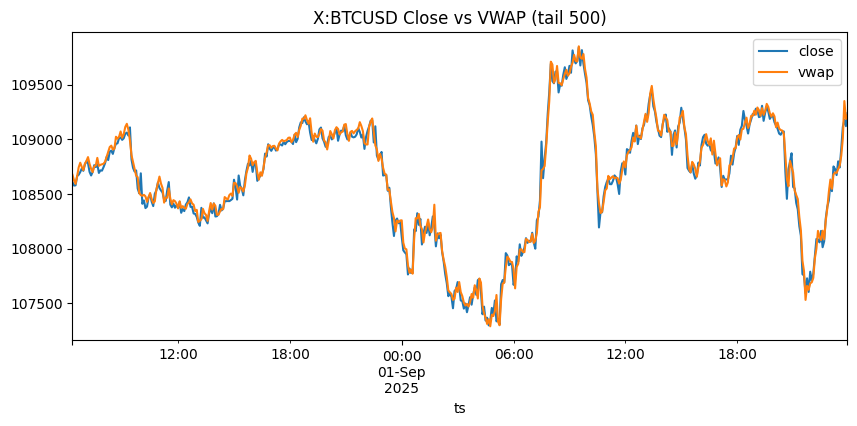

In [9]:
# 5) Feature Engineering
for sym, df in assets_data.items():
    if 'vwap' not in df or df['vwap'].isna().mean() > 0.1:
        df['vwap'] = compute_vwap(df)
    df['ma20'] = df['close'].rolling(20, min_periods=5).mean()
    df['sigma20'] = df['close'].pct_change().rolling(20, min_periods=5).std()
    df['atr14'] = atr(df, 14)
    df['tod'] = time_of_day_bucket(df.index, sym)

# Sample plot
one = ASSETS[0]
fig1, ax = plt.subplots(1,1, figsize=(10,4))
assets_data[one][['close','vwap']].tail(500).plot(ax=ax)
ax.set_title(f'{one} Close vs VWAP (tail 500)')
plt.show()


### 6) Higher-TF Hurst Context
Resample to 1H, compute rolling Hurst (R/S), smooth with EMA, label regimes.
- Bands: MR ≤ 0.45, NOISY 0.45–0.55, TREND ≥ 0.55
- Plot H with bands and show regime proportions


In [11]:
# Normalize indexes to UTC DatetimeIndex
for sym, df in assets_data.items():
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index, utc=True, errors='coerce')
    elif df.index.tz is None:
        df.index = df.index.tz_localize('UTC')
    else:
        df.index = df.index.tz_convert('UTC')
    df.sort_index(inplace=True)

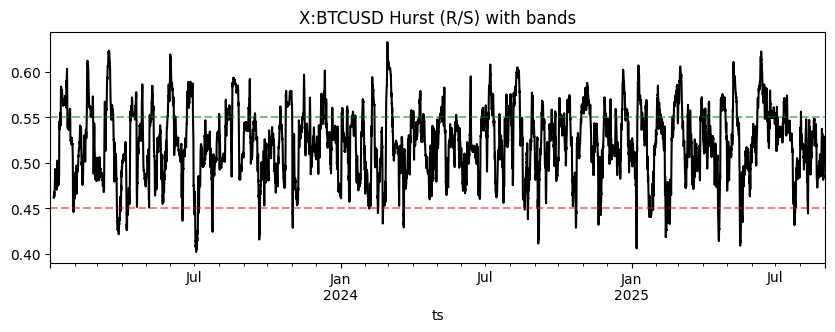

,asset,regime,p
0,X:BTCUSD,NOISY,72.42
1,X:BTCUSD,TREND,23.91
2,X:BTCUSD,MR,3.67
3,X:ETHUSD,NOISY,70.65
4,X:ETHUSD,TREND,27.15
5,X:ETHUSD,MR,2.20
6,X:SOLUSD,NOISY,77.53
7,X:SOLUSD,TREND,20.87
8,X:SOLUSD,MR,1.60
9,X:XRPUSD,NOISY,76.70


In [12]:
# 6) Higher-TF Hurst Context
H_values, H_regimes = {}, {}
for sym, df in assets_data.items():
    r = df['close'].resample('h').last().pct_change(fill_method=None).dropna()
    H = rolling_hurst(r, win=H_WIN, ema_span=H_EMA)
    H_values[sym] = H
    H_regimes[sym] = label_h_regime(H, low=H_BANDS[0], high=H_BANDS[1])

# Plot H for one asset
fig_h, ax = plt.subplots(1,1, figsize=(10,3))
H_values[one].plot(ax=ax, color='k')
ax.axhline(H_BANDS[0], color='r', ls='--', alpha=0.5)
ax.axhline(H_BANDS[1], color='g', ls='--', alpha=0.5)
ax.set_title(f'{one} Hurst (R/S) with bands')
plt.show()

# Regime proportions
reg_props = []
for sym, reg in H_regimes.items():
    props = reg.value_counts(normalize=True)
    for k, v in props.items():
        reg_props.append({'asset': sym, 'regime': k, 'p': round(100*v,2)})
regime_table = pd.DataFrame(reg_props)
regime_table


In [13]:
for sym in ASSETS:
    H = H_values[sym].dropna()
    reg = H_regimes[sym].dropna()
    print(f'\n{sym}')
    print('H mean/median/min/max:', round(H.mean(),3), round(H.median(),3), round(H.min(),3), round(H.max(),3))
    print('H in [0,1]:', bool((H.between(0,1)).all()))
    props = (reg.value_counts(normalize=True)*100).round(2)
    print('Regime %:', props.to_dict(), 'Total:', round(props.sum(),2))


X:BTCUSD
H mean/median/min/max: 0.522 0.522 0.402 0.633
H in [0,1]: True
Regime %: {'NOISY': 72.42, 'TREND': 23.91, 'MR': 3.67} Total: 100.0

X:ETHUSD
H mean/median/min/max: 0.525 0.526 0.407 0.654
H in [0,1]: True
Regime %: {'NOISY': 70.65, 'TREND': 27.15, 'MR': 2.2} Total: 100.0

X:SOLUSD
H mean/median/min/max: 0.522 0.523 0.398 0.618
H in [0,1]: True
Regime %: {'NOISY': 77.53, 'TREND': 20.87, 'MR': 1.6} Total: 100.0

X:BNBUSD
H mean/median/min/max: nan nan nan nan
H in [0,1]: True
Regime %: {} Total: 0.0

X:XRPUSD
H mean/median/min/max: 0.517 0.519 0.418 0.619
H in [0,1]: True
Regime %: {'NOISY': 76.7, 'TREND': 20.47, 'MR': 2.83} Total: 100.0

X:ADAUSD
H mean/median/min/max: 0.521 0.52 0.407 0.622
H in [0,1]: True
Regime %: {'NOISY': 75.61, 'TREND': 22.28, 'MR': 2.11} Total: 100.0

X:DOGEUSD
H mean/median/min/max: 0.52 0.52 0.416 0.639
H in [0,1]: True
Regime %: {'NOISY': 75.26, 'TREND': 21.78, 'MR': 2.97} Total: 100.01

X:AVAXUSD
H mean/median/min/max: 0.527 0.529 0.412 0.642
H in

### 7) Event Labeling (Anchored VWAP Reversion)
Trigger on |close − anchored VWAP|/anchored VWAP ≥ threshold; success when the signed deviation flips sign within N bars.
- Anchored VWAP resets per UTC day (computed in helpers)
- Outputs: trigger, success, side, time-to-reversion (ttr)


In [16]:
# 7) Event Labeling (VWAP Reversion)
th = DEV_THRESH[1]
hz = HORIZONS[1]
labels = {}
for sym, df in assets_data.items():
    trig, succ, side, ttr = label_vwap_reversion(df, threshold_pct=th, horizon=hz)
    labels[sym] = {'trigger': trig, 'success': succ, 'side': side, 'ttr': ttr}
    print(sym, 'trig:', int(trig.sum()), 'succ:', int((succ & trig).sum()))

sum_tbl = []
for sym in ASSETS:
    t = int(labels[sym]['trigger'].sum())
    s = int((labels[sym]['success'] & labels[sym]['trigger']).sum())
    sum_tbl.append({'asset': sym, 'triggers': t, 'success': s, 'p': round(s/max(t,1),3)})
pd.DataFrame(sum_tbl)


X:BTCUSD trig: 39546 succ: 3507
X:ETHUSD trig: 62297 succ: 5216
X:SOLUSD trig: 109022 succ: 10666
X:BNBUSD trig: 0 succ: 0
X:XRPUSD trig: 73475 succ: 7143
X:ADAUSD trig: 96739 succ: 9310
X:DOGEUSD trig: 96933 succ: 9894
X:AVAXUSD trig: 112535 succ: 10894
X:DOTUSD trig: 94946 succ: 8572
X:MATICUSD trig: 100918 succ: 10059


,asset,triggers,success,p
0,X:BTCUSD,39546,3507,0.089
1,X:ETHUSD,62297,5216,0.084
2,X:SOLUSD,109022,10666,0.098
3,X:BNBUSD,0,0,0.000
4,X:XRPUSD,73475,7143,0.097
5,X:ADAUSD,96739,9310,0.096
6,X:DOGEUSD,96933,9894,0.102
7,X:AVAXUSD,112535,10894,0.097
8,X:DOTUSD,94946,8572,0.090
9,X:MATICUSD,100918,10059,0.100


### 8) EDA — Base and Conditionals
Compute base P(revert) by regime, and conditionals by deviation bin × regime × side.


In [17]:
# 8) EDA — Frequency, Base Edge, Conditionals
base_rows = []
cond_tables = []
for sym, df in assets_data.items():
    reg = H_regimes[sym].reindex(df.index, method='ffill')
    trig = labels[sym]['trigger']
    succ = labels[sym]['success']
    side = labels[sym]['side']

    # Base per regime
    for r in ['MR','NOISY','TREND']:
        m = (reg == r)
        n_trig = int((trig & m).sum())
        n_succ = int((succ & trig & m).sum())
        p = (n_succ / n_trig) if n_trig > 0 else np.nan
        base_rows.append({'asset': sym, 'regime': r, 'triggers': n_trig, 'success': n_succ, 'p': p})

    # Conditionals: deviation x regime x side
    dev_abs = deviation_pct_from_vwap(df['close'], df['vwap']).abs()
    dev_bin = pd.cut(dev_abs, bins=[-1, DEV_THRESH[0], DEV_THRESH[1], DEV_THRESH[2], 1e9], labels=['<t0','t0-t1','t1-t2','>t2'])
    tbl = conditional_probability_table((succ & trig), {'dev': dev_bin, 'reg': reg, 'side': side})
    tbl['asset'] = sym
    cond_tables.append(tbl)

base_table = pd.DataFrame(base_rows)
cond_table = pd.concat(cond_tables, ignore_index=True)

base_table.head(), cond_table.head()


/var/folders/28/nnvxcjr149d4zt1c754qjrp40000gn/T/ipykernel_4981/3576870998.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cond_table = pd.concat(cond_tables, ignore_index=True)
/var/folders/28/nnvxcjr149d4zt1c754qjrp40000gn/T/ipykernel_4981/3576870998.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cond_table = pd.concat(cond_tables, ignore_index=True)


(      asset regime  triggers  success         p
 0  X:BTCUSD     MR      1043      100  0.095877
 1  X:BTCUSD  NOISY     26584     2301  0.086556
 2  X:BTCUSD  TREND     11919     1106  0.092793
 3  X:ETHUSD     MR       998       99  0.099198
 4  X:ETHUSD  NOISY     40288     3132  0.077740,
    dev    reg  side         p       n     asset
 0  <t0     MR  down  0.002390    5440  X:BTCUSD
 1  <t0     MR    up  0.017842    4820  X:BTCUSD
 2  <t0  NOISY  down  0.010386   98498  X:BTCUSD
 3  <t0  NOISY    up  0.012132  103774  X:BTCUSD
 4  <t0  TREND  down  0.015172   32099  X:BTCUSD)

### 9) Monotonicity Check & Stability Check
Ensure P(revert) increases with larger deviation bins within each regime/side.
Compare first vs second half; report max/median absolute delta in P(revert).

In [18]:
from helpers import monotonicity_check, stability_summary

# cond_table already built earlier
mono_pass, mono_df = monotonicity_check(cond_table)

stab_df = stability_summary(assets_data, H_regimes, labels, DEV_THRESH)
print('Monotonicity pass rate:', round(mono_pass, 3))
stab_df

/Users/justinborneo/Desktop/Desktop - Justin’s MacBook Pro/Trading Research/helpers.py:629: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dev_order: Optional[List[str]] = None,


Monotonicity pass rate: 0.815


,asset,max_abs_delta_p,median_abs_delta_p
0,X:BTCUSD,0.072917,0.002324
1,X:ETHUSD,0.104167,0.012561
2,X:SOLUSD,0.157895,0.018462
3,X:BNBUSD,NaN,NaN
4,X:XRPUSD,0.304348,0.054161
5,X:ADAUSD,0.208333,0.044444
6,X:DOGEUSD,0.304348,0.031383
7,X:AVAXUSD,0.142857,0.010570
8,X:DOTUSD,0.160000,0.030041
9,X:MATICUSD,0.453333,0.056042


In [22]:
# Asset-level decision and filtering
KEEP_ASSETS, REJECTS = [], []
for sym in sorted(base_table['asset'].unique()):
    bt = base_table[base_table['asset'] == sym]
    ct = cond_table[cond_table['asset'] == sym]
    sd = stab_df[stab_df['asset'] == sym]
    dec, why = decision_gate(
        bt, ct, sd,
        min_triggers=2000,      # per-asset min triggers
        min_mono_pass=0.6,
        max_median_delta=0.03   # slightly looser for alts
    )
    (KEEP_ASSETS if dec == 'KEEP' else REJECTS).append((sym, why))

print('KEEP_ASSETS:', [a for a,_ in KEEP_ASSETS])
print('REJECTS:', REJECTS)

# Optional: restrict downstream to kept assets only
if KEEP_ASSETS:
    kept = {a for a,_ in KEEP_ASSETS}
    assets_data = {k:v for k,v in assets_data.items() if k in kept}
    # Rebuild base_table/cond_table/etc if you want fully filtered EDA

KEEP_ASSETS: ['X:AVAXUSD', 'X:BTCUSD', 'X:ETHUSD', 'X:SOLUSD']
REJECTS: [('X:ADAUSD', ['stability weak: median |Δp|=0.044 > 0.030']), ('X:BNBUSD', ['too few triggers: 0 < 2000', 'monotonicity weak: pass_rate=0.00 < 0.60', 'stability weak: median |Δp|=nan > 0.030']), ('X:DOGEUSD', ['stability weak: median |Δp|=0.031 > 0.030']), ('X:DOTUSD', ['stability weak: median |Δp|=0.030 > 0.030']), ('X:MATICUSD', ['stability weak: median |Δp|=0.056 > 0.030']), ('X:XRPUSD', ['stability weak: median |Δp|=0.054 > 0.030'])]


/Users/justinborneo/Desktop/Desktop - Justin’s MacBook Pro/Trading Research/helpers.py:629: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dev_order: Optional[List[str]] = None,
/Users/justinborneo/Desktop/Desktop - Justin’s MacBook Pro/Trading Research/helpers.py:629: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dev_order: Optional[List[str]] = None,
/Users/justinborneo/Desktop/Desktop - Justin’s MacBook Pro/Trading Research/helpers.py:629: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or ob

### 11) Decision Gate (EDA-only)
Use helpers-based decision_gate to print KEEP or STOP and reasons based on triggers, monotonicity, and stability.


In [24]:
# 11) Decision Gate (per-asset aware)
from helpers import decision_gate

if 'KEEP_ASSETS' in globals() and KEEP_ASSETS:
    DECISION = 'KEEP'
    reasons = []
    print('Decision:', DECISION)
    print('Assets kept:', KEEP_ASSETS)
else:
    DECISION, reasons = decision_gate(base_table, cond_table, stab_df,
                                      min_triggers=200, min_mono_pass=0.6, max_median_delta=0.02)
    print('Decision:', DECISION)
    if reasons:
        print('Reasons:')
        for r in reasons:
            print('-', r)

# Make kept assets available to later cells (packaging)
KEPT_ASSETS = KEEP_ASSETS if ('KEEP_ASSETS' in globals() and KEEP_ASSETS) else list(sorted(base_table['asset'].unique()))

Decision: KEEP
Assets kept: [('X:AVAXUSD', []), ('X:BTCUSD', []), ('X:ETHUSD', []), ('X:SOLUSD', [])]


### 12) Visuals — Kept Assets
Additional multi-asset visuals focusing on kept assets:
- Per-asset heatmaps (Deviation × Regime)
- Per-asset reliability curves (Deviation bin vs P(revert))
- Bar chart: base P(revert) by regime & asset
- Time-of-day curves (per asset)


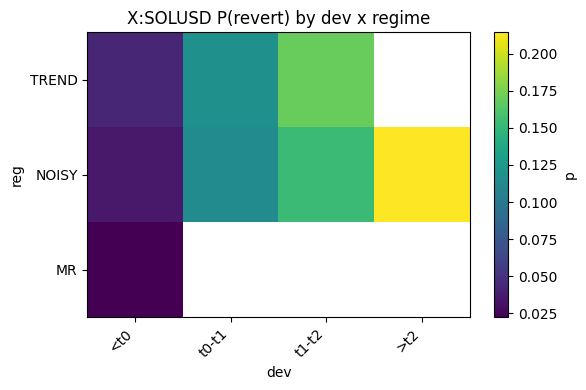

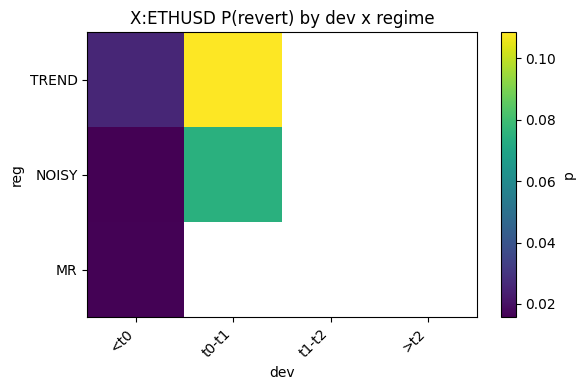

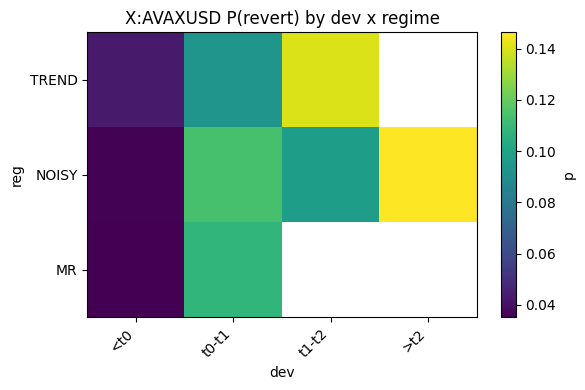

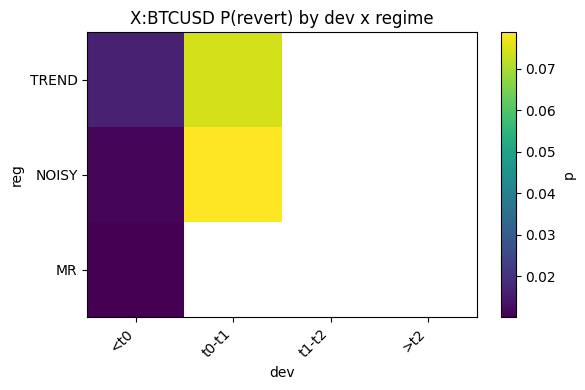

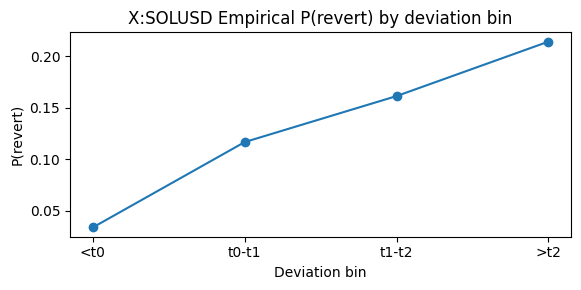

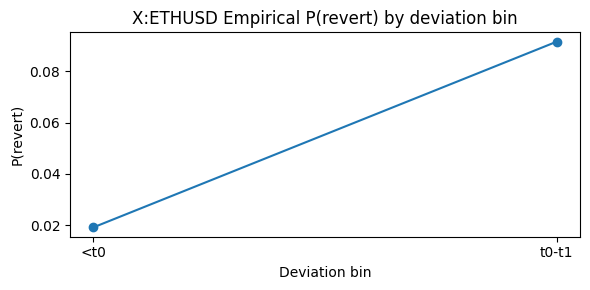

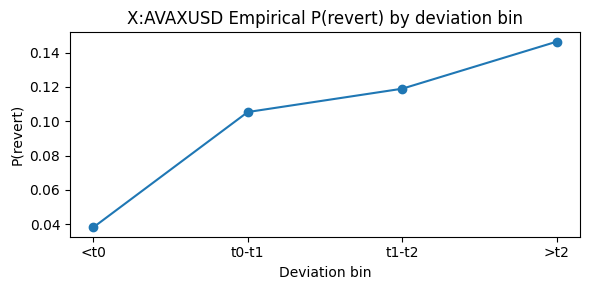

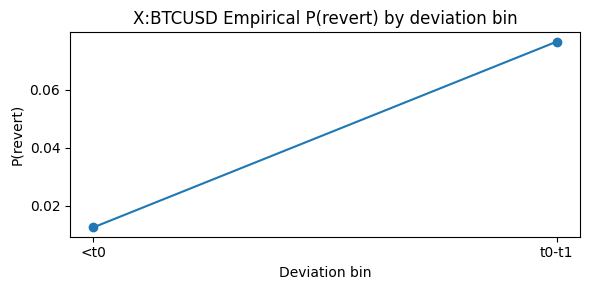

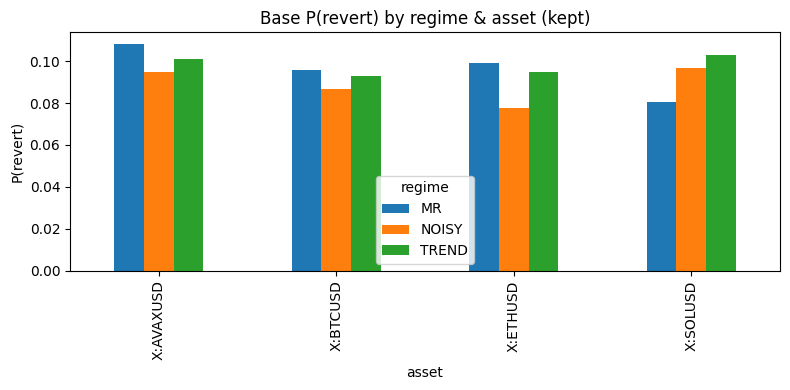

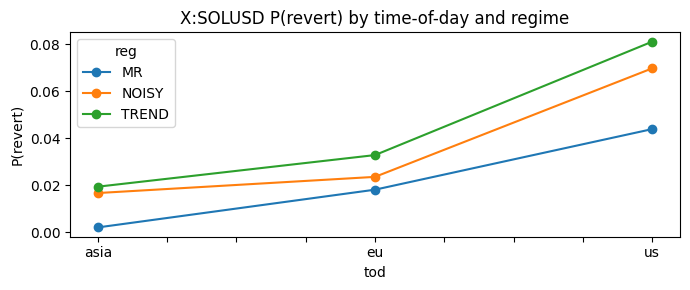

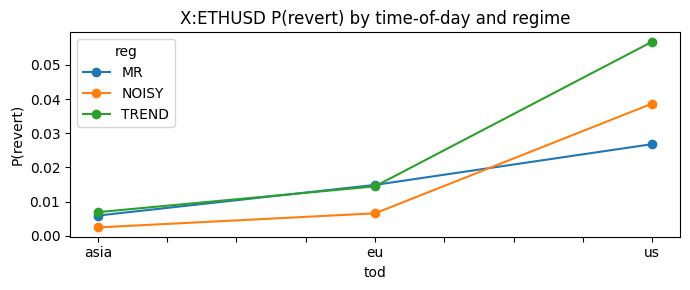

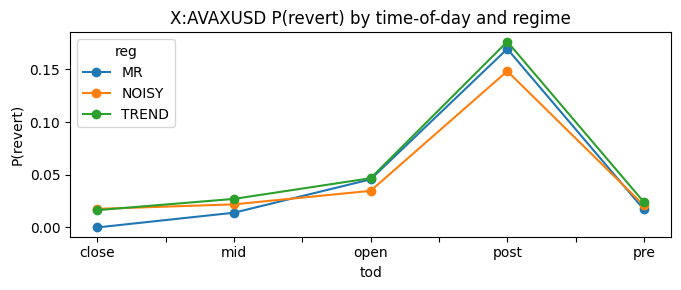

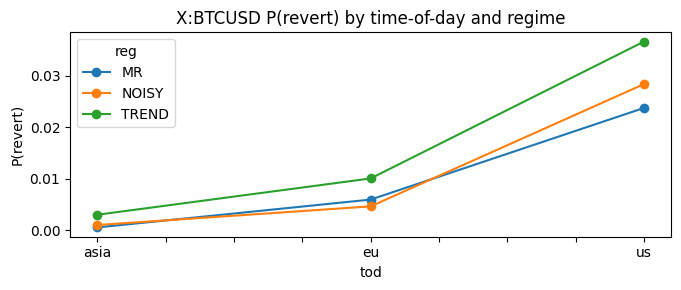

In [27]:
# Visuals for kept assets
kept_list = KEPT_ASSETS if 'KEPT_ASSETS' in globals() else list(base_table['asset'].unique())
kept = {a if isinstance(a, str) else a[0] for a in kept_list}
# Per-asset heatmaps
fig_heat_assets = {}
for sym in kept:
    one_tbl = cond_table[cond_table['asset']==sym]
    if one_tbl.empty:
        continue
    ht = one_tbl.groupby(['dev','reg'], observed=True)['p'].mean().reset_index()
    fig = plot_heatmap(ht, x='dev', y='reg', value='p', title=f'{sym} P(revert) by dev x regime')
    fig_heat_assets[sym] = fig

# Per-asset reliability curves
fig_rel_assets = {}
for sym in kept:
    one_tbl = cond_table[cond_table['asset']==sym]
    if one_tbl.empty:
        continue
    ht = one_tbl.groupby(['dev'], observed=True)['p'].mean().reset_index()
    fig, ax = plt.subplots(1,1, figsize=(6,3))
    ax.plot(ht['dev'].astype(str), ht['p'], marker='o')
    ax.set_title(f'{sym} Empirical P(revert) by deviation bin')
    ax.set_xlabel('Deviation bin')
    ax.set_ylabel('P(revert)')
    plt.tight_layout()
    fig_rel_assets[sym] = fig

# Base P(revert) by regime & asset (bar chart)
fig_base, ax = plt.subplots(1,1, figsize=(8,4))
base_kept = base_table[base_table['asset'].isin(kept)]
base_pivot = base_kept.pivot(index='asset', columns='regime', values='p')
base_pivot.plot(kind='bar', ax=ax)
ax.set_title('Base P(revert) by regime & asset (kept)')
ax.set_ylabel('P(revert)')
plt.tight_layout()

# Time-of-day curves (per asset)
fig_tod_assets = {}
DEV_ORDER = ['<t0','t0-t1','t1-t2','>t2']
for sym in kept:
    df = assets_data.get(sym)
    if df is None or df.empty:
        continue
    reg = H_regimes[sym].reindex(df.index, method='ffill')
    trig = labels[sym]['trigger']
    succ = labels[sym]['success']
    dev_abs = (df['close']/df['vwap'] - 1).abs()*100
    dev_bin = pd.cut(dev_abs, bins=[-1, DEV_THRESH[0], DEV_THRESH[1], DEV_THRESH[2], 1e9], labels=DEV_ORDER)
    tod = df['tod']
    tbl = conditional_probability_table((succ & trig), {'tod': tod, 'reg': reg})
    if tbl.empty:
        continue
    fig, ax = plt.subplots(1,1, figsize=(7,3))
    pivot = tbl.pivot(index='tod', columns='reg', values='p')
    pivot.plot(ax=ax, marker='o')
    ax.set_title(f'{sym} P(revert) by time-of-day and regime')
    ax.set_ylabel('P(revert)')
    plt.tight_layout()
    fig_tod_assets[sym] = fig


### Packing and Final Summary 

### 13) Packaging — include all key figures and tables
Saves config, summary tables, and all visuals (including per-asset) into `studies/<timestamp>_VWAP_Reversion/plots/`.


In [28]:
# 13) Packaging — include all key figures and tables
# Collect figures
figures = {
    'hurst_regimes': fig_h,
    'heatmap_global': fig_heat,
    'reliability_global': fig_rel,
}

# Add per-asset visuals if present
if 'fig_heat_assets' in globals():
    for sym, fig in fig_heat_assets.items():
        figures[f'heatmap_{sym}'] = fig
if 'fig_rel_assets' in globals():
    for sym, fig in fig_rel_assets.items():
        figures[f'reliability_{sym}'] = fig
if 'fig_tod_assets' in globals():
    for sym, fig in fig_tod_assets.items():
        figures[f'tod_{sym}'] = fig
if 'fig_base' in globals():
    figures['base_regime_bar'] = fig_base
if 'fig_ttrs' in globals():
    for sym, fig in fig_ttrs.items():
        figures[f'ttr_{sym}'] = fig

# Tables to save
tables = {
    'eda_summary': base_table.copy(),
}
if 'cond_table' in globals():
    tables['eda_conditionals'] = cond_table.copy()
if 'regime_table' in globals():
    tables['regime_props'] = regime_table.copy()
if 'coverage' in globals():
    tables['coverage'] = coverage.copy()

# Config
cfg = dict(
    ASSETS=ASSETS,
    KEPT_ASSETS=(KEPT_ASSETS if 'KEPT_ASSETS' in globals() else ASSETS),
    START=START,
    END=END,
    INTRADAY_MULTIPLIER=INTRADAY_MULTIPLIER,
    H_WIN=H_WIN,
    H_EMA=H_EMA,
    H_BANDS=H_BANDS,
    DEV_THRESH=DEV_THRESH,
    HORIZONS=HORIZONS,
    STUDY_NAME=STUDY_NAME,
    DECISION=DECISION,
)

out_dir = package_study(STUDY_NAME, cfg, figures, tables)
print('Packaged to:', out_dir)


Packaged to: studies/20250915_202810_VWAP_Reversion


In [29]:
# 14) Final Summary
from IPython.display import Markdown, display

# Metrics for summary
kept = KEPT_ASSETS if 'KEPT_ASSETS' in globals() else ASSETS
if isinstance(kept, list) and kept and isinstance(kept[0], tuple):
    kept = [a for a,_ in kept]

if 'base_table' in globals():
    bt_kept = base_table[base_table['asset'].isin(kept)]
    total_trigs = int(bt_kept['triggers'].sum()) if len(bt_kept) else 0
    avg_p = float(bt_kept['p'].mean()) if len(bt_kept) else float('nan')
else:
    total_trigs, avg_p = 0, float('nan')

# Monotonicity/stability
if 'mono_pass' in globals():
    mono_rate = mono_pass
elif 'cond_table' in globals():
    from helpers import monotonicity_check
    mono_rate, _ = monotonicity_check(cond_table)
else:
    mono_rate = float('nan')

if 'stab_df' in globals() and len(stab_df):
    stab_kept = stab_df[stab_df['asset'].isin(kept)]
    median_delta = float(stab_kept['median_abs_delta_p'].median()) if len(stab_kept) else float('nan')
else:
    median_delta = float('nan')

summary = f"""
- Study: VWAP Reversion EDA
- Span: {START} → {END}
- Decision: {DECISION}
- Assets (kept): {kept}
- Triggers (kept): {total_trigs}
- Mean P(revert) (kept): {avg_p:.3f}
- Monotonicity pass rate: {mono_rate:.2f}
- Stability median |Δp|: {median_delta:.3f}
- Packaged: {out_dir}
"""
display(Markdown(summary))



- Study: VWAP Reversion EDA
- Span: 2023-01-01 → 2025-09-01
- Decision: KEEP
- Assets (kept): ['X:AVAXUSD', 'X:BTCUSD', 'X:ETHUSD', 'X:SOLUSD']
- Triggers (kept): 322231
- Mean P(revert) (kept): 0.094
- Monotonicity pass rate: 0.81
- Stability median |Δp|: 0.012
- Packaged: studies/20250915_202810_VWAP_Reversion
